In [27]:
from rdkit import Chem
from rdkit.Chem import PandasTools, Draw
from rdkit.Chem import Crippen, QED, RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key,ROMol
0,CHEMBL6329,Cc1cc(ccc1C(=O)c2ccccc2Cl)N3N=CC(=O)NC3=O,InChI=1S/C17H12ClN3O3/c1-10-8-11(21-17(24)20-1...,OWRSAHYFSSNENM-UHFFFAOYSA-N,
1,CHEMBL6328,Cc1cc(ccc1C(=O)c2ccc(cc2)C#N)N3N=CC(=O)NC3=O,InChI=1S/C18H12N4O3/c1-11-8-14(22-18(25)21-16(...,ZJYUMURGSZQFMH-UHFFFAOYSA-N,
2,CHEMBL265667,Cc1cc(cc(C)c1C(O)c2ccc(Cl)cc2)N3N=CC(=O)NC3=O,InChI=1S/C18H16ClN3O3/c1-10-7-14(22-18(25)21-1...,YOMWDCALSDWFSV-UHFFFAOYSA-N,
3,CHEMBL6362,Cc1ccc(cc1)C(=O)c2ccc(cc2)N3N=CC(=O)NC3=O,InChI=1S/C17H13N3O3/c1-11-2-4-12(5-3-11)16(22)...,PSOPUAQFGCRDIP-UHFFFAOYSA-N,
4,CHEMBL267864,Cc1cc(ccc1C(=O)c2ccc(Cl)cc2)N3N=CC(=O)NC3=O,InChI=1S/C17H12ClN3O3/c1-10-8-13(21-17(24)20-1...,KEZNSCMBVRNOHO-UHFFFAOYSA-N,

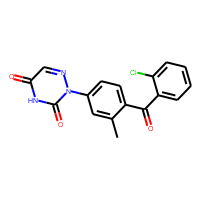
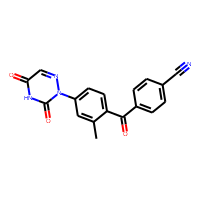
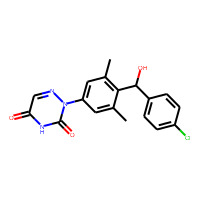
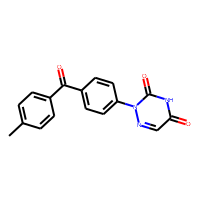
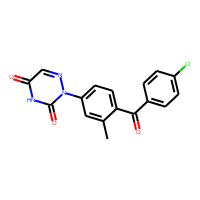

In [35]:
df = pd.read_csv("../data/chembl/chembl.txt", nrows=100, delim_whitespace=True)
PandasTools.AddMoleculeColumnToFrame(df, 'canonical_smiles')
df.head()

In [28]:
# add rdkit descriptors

# water octanol partition coefficient
df['logP'] = df['ROMol'].apply(lambda x: Crippen.MolLogP(x))

# quantitative estimation of drug-likeness
# 0-1, higher = more drug-like
df['qed'] = df['ROMol'].apply(lambda x: QED.qed(x))

# synthetic accessibility score
df['sas'] = df['ROMol'].apply(lambda x: sascorer.calculateScore(x))

,chembl_id,ROMol,logP,qed,sas
0,CHEMBL6329,,2.11362,0.739338,2.257318
1,CHEMBL6328,,1.33190,0.727894,2.352583
2,CHEMBL265667,,2.27274,0.752308,2.940356
3,CHEMBL6362,,1.46022,0.742386,2.039585
4,CHEMBL267864,,2.11362,0.739338,2.209386

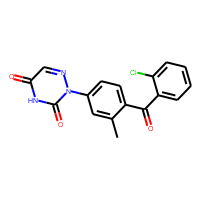
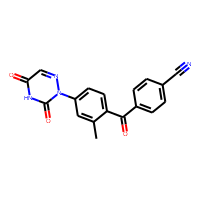
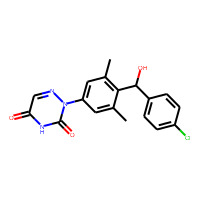
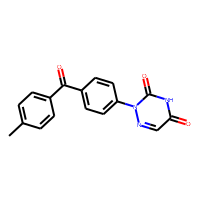
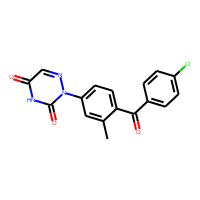

In [32]:
to_drop = ['canonical_smiles', 'standard_inchi', 'standard_inchi_key']
df.drop(to_drop, axis=1).head()

In [37]:
# zinc 250k stats

zinc = pd.read_csv('../data/zinc/250k_rndm_zinc_drugs_clean_3.csv')
zinc.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [84]:
def plot_distrib(df, col, ax = None, **kwargs):
    
    if ax is None:
        ax = plt.gca()
        
    ax.hist(df[col], bins='auto', density=True, **kwargs)
    
    mean = df[col].mean()
    std = df[col].std()
    
    ax.axvspan(mean - std, mean + std, color='red', alpha=0.1)
    ax.axvline(mean, color='red', lw=2, label=f'Mean = {mean:.2f}')
    
    ax.grid(alpha=0.2)
    ax.set_axisbelow(True)
    ax.set_title(col, size=14)
    ax.legend()

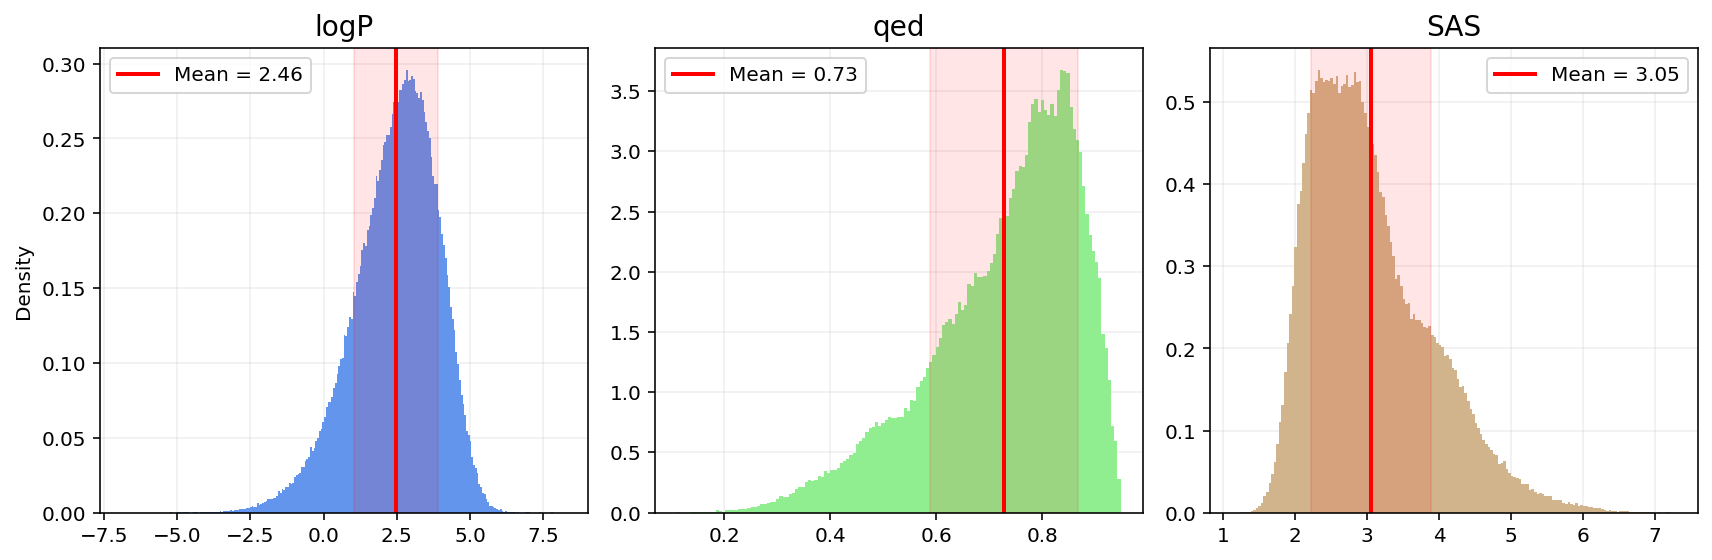

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

plot_distrib(zinc, 'logP', color='cornflowerblue', ax=ax[0])
plot_distrib(zinc, 'qed', color='lightgreen', ax=ax[1])
plot_distrib(zinc, 'SAS', color='tan', ax=ax[2])

ax[0].set_ylabel('Density')
plt.tight_layout()

In [101]:
means = zinc[['logP', 'qed', 'SAS']].mean().values
stds = zinc[['logP', 'qed', 'SAS']].std().values

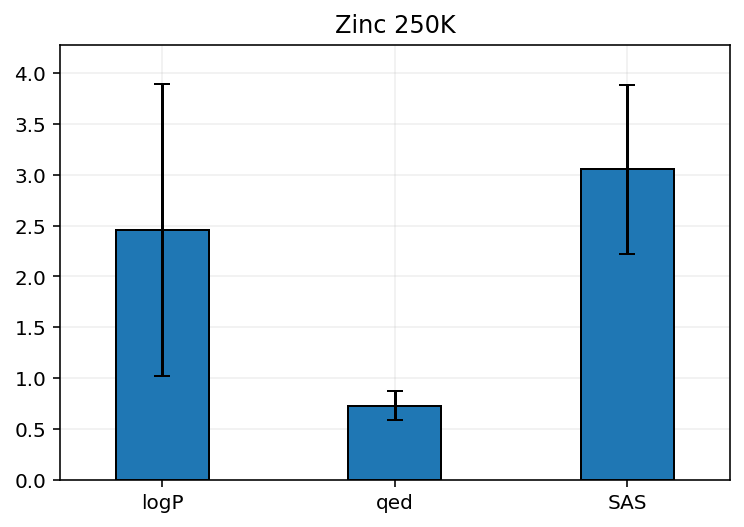

In [116]:
x = range(len(means))

plt.bar(x, means, yerr=stds, width=0.4, capsize=4, edgecolor='k')
plt.title('Zinc 250K')
plt.grid(alpha=0.2)
plt.gca().set_axisbelow(True)
plt.xticks(x, ['logP', 'qed', 'SAS']);
plt.margins(0.1)